# Kalman via optimisation


In [2]:
import os
import pandas as pd
import sys
from eks.utils import convert_lp_dlc
from eks.multiview_pca_smoother import ensemble_kalman_smoother_multi_cam
from eks.newton_eks import *
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm.notebook as tqdm
from scipy.optimize import *
import scipy as sp

## pupil example data (linear case)

In [448]:
pupil1 = "/Users/clairehe/Documents/GitHub/eks/data/ibl-pupil/5285c561-80da-4563-8694-739da92e5dd0.left.rng=0.csv"
df_pupil = pd.read_csv(pupil1, header=[0,1,2], index_col=0)
df_pupil.head()

scorer    heatmap_mhcrnn_tracker                                      \
bodyparts            pupil_top_r                       pupil_right_r   
coords                         x          y likelihood             x   
0                      53.971542  40.784889   0.996096     63.997185   
1                      53.971542  40.784889   0.996096     63.997185   
2                      53.971542  40.784889   0.996096     63.997185   
3                      54.682766  41.602886   0.994934     64.214340   
4                      54.535515  41.143906   0.999473     64.464943   

scorer                                                                \
bodyparts                       pupil_bottom_r                         
coords             y likelihood              x          y likelihood   
0          50.457775   0.998967      54.795803  61.129665   0.995241   
1          50.457775   0.998967      54.795803  61.129665   0.995241   
2          50.457775   0.998967      54.795803  61.129665   0.995241   
3          50.438499   0.996683      55.169212  61.332661   0.999601   
4          50.506241   0.999723      55.322891  60.785454   0.999518   

scorer                                        
bodyparts pupil_left_r                        
coords               x          y likelihood  
0            42.372387  51.355415   0.996667  
1            42.372387  51.355415   0.996667  
2            42.372387  51.355415   0.996667  
3            43.415447  50.964855   0.998236  
4            44.182907  51.238132   0.999794

In [449]:
%run -i 'scripts/pupil_example.py' --csv-dir 'data/ibl-pupil' --save-dir 'data/misc/pupil-test/' --diameter-s 0.99 --com-s 0.99 

Smoothing matrix: [[0.99 0.   0.  ]
 [0.   0.99 0.  ]
 [0.   0.   0.99]]
filtering...
done filtering
smoothing...
done smoothing
saving smoothed predictions to data/misc/pupil-test/kalman_smoothed_pupil_traces.csv
saving latents to data/misc/pupil-test/kalman_smoothed_latents.csv
see example EKS output at data/misc/pupil-test/example_eks_result.pdf


In [33]:
### Preprocess data

from eks.utils import make_dlc_pandas_index
from eks.ensemble_kalman import ensemble
from eks.pupil_utils import get_pupil_location, get_pupil_diameter


# compute ensemble median
keys = ['pupil_top_r_x', 'pupil_top_r_y', 'pupil_bottom_r_x', 'pupil_bottom_r_y',
        'pupil_right_r_x', 'pupil_right_r_y', 'pupil_left_r_x', 'pupil_left_r_y']
ensemble_preds, ensemble_vars, ensemble_stacks, keypoints_mean_dict, keypoints_var_dict, keypoints_stack_dict = ensemble(
    markers_list, keys)

# ## Set parameters
# compute center of mass
pupil_locations = get_pupil_location(keypoints_mean_dict)
pupil_diameters = get_pupil_diameter(keypoints_mean_dict)
diameters = []
for i in range(len(markers_list)):
    keypoints_dict = keypoints_stack_dict[i]
    diameter = get_pupil_diameter(keypoints_dict)
    diameters.append(diameter)

mean_x_obs = np.mean(pupil_locations[:, 0])
mean_y_obs = np.mean(pupil_locations[:, 1])
# make the mean zero
x_t_obs, y_t_obs = pupil_locations[:, 0] - mean_x_obs, pupil_locations[:, 1] - mean_y_obs

scaled_ensemble_preds = ensemble_preds.copy()
scaled_ensemble_stacks = ensemble_stacks.copy()
# subtract COM means from the ensemble predictions
for i in range(ensemble_preds.shape[1]):
    if i % 2 == 0:
        scaled_ensemble_preds[:, i] -= mean_x_obs
    else:
        scaled_ensemble_preds[:, i] -= mean_y_obs
# subtract COM means from all the predictions
for i in range(ensemble_preds.shape[1]):
    if i % 2 == 0:
        scaled_ensemble_stacks[:, :, i] -= mean_x_obs
    else:
        scaled_ensemble_stacks[:, :, i] -= mean_y_obs
y = scaled_ensemble_preds

mean_array = np.array([0, mean_x_obs, mean_y_obs])

In [34]:
a, b, c = np.var(pupil_diameters),np.var(x_t_obs),np.var(y_t_obs)

In [35]:
### Initial states

r = 3
T = 2000
mu0 = np.asarray([np.mean(pupil_diameters), 0.0, 0.0])

# diagonal: var
S0 = np.asarray([
    [np.var(pupil_diameters), 0.0, 0.0],
    [0.0, np.var(x_t_obs), 0.0],
    [0.0, 0.0, np.var(y_t_obs)]
])

A = np.asarray([
    [0.99, 0, 0],
    [0, 0.99, 0],
    [0, 0, 0.99]
])
B = np.asarray([[0, 1, 0], [-.5, 0, 1], [0, 1, 0], 
                [.5, 0, 1], [.5, 1, 0], [0, 0, 1], 
                [-.5, 1, 0],[0, 0, 1]])

# state covariance matrix
E = np.asarray([
        [np.var(pupil_diameters) * (1 - (A[0, 0] ** 2)), 0, 0],
        [0, np.var(x_t_obs) * (1 - A[1, 1] ** 2), 0],
        [0, 0, np.var(y_t_obs) * (1 - (A[2, 2] ** 2))]
    ])

D = np.eye(8)

print(ensemble_vars.shape)

(2000, 8)


In [36]:
pupil_latent = pd.read_csv("/Users/clairehe/Documents/GitHub/eks/data/misc/pupil-test/kalman_smoothed_latents.csv", header=[0,1], index_col=0)
pupil_latent.head()

scorer ensemble-kalman_tracker                      
latent                diameter      com_x      com_y
0                    19.820629  54.719227  50.747470
1                    19.707099  54.772514  50.759262
2                    19.554894  54.870607  50.772020
3                    19.337871  55.074898  50.760586
4                    19.162826  55.176431  50.757116

In [37]:
def hessian(y, mu0, S0, A, B, ensemble_vars, E, plot = False):
    """ Calculates hessian for log p(Q|Y)
        obs : y_t|q_t = f(q_t)+ N(0, D_t) if linear, f(q) = B*q 
        latent : q_t|q_{t-1} = A*q_{t-1}+N(0,E)
        
    Args:
        y: np.ndarray -- Each column is the vector of observations of keypoint
            shape (n_samples, n_keypoints)
        mu0: np.ndarray -- initial offset
            shape (n_latents)
        A: np.ndarray -- Latent matrix
            shape (n_latents, n_latents)
        B: np.ndarray -- Observation matrix
            shape (n_keypoints, n_latents)
        ensemble_vars: np.ndarray -- ensemble variance 
            shape (n_samples, n_keypoints)
        E: np.ndarray -- latent variance
            shape (n_latents, n_latents)

     """ 
    T = y.shape[0]
    r = mu0.shape[0]
    n = y.shape[1]
    D = np.zeros((n,n))
    invE = np.linalg.inv(E)
    H = np.zeros((T, T))

    for t in tqdm.tqdm(range(0,T-r)):
        D = np.diag(ensemble_vars[t])
        invD = np.linalg.inv(D)
        H[t:t+r, t:t+r] =  (B.T @ invD @ B + A.T @ invE @ A + invE)
        if t+2*r <= T:
            H[t:t+r, t+r:t+2*r] = - (A.T @ invE)
            H[t+r:t+2*r, t:t+r] = -(A.T @ invE).T  

    H[T-r:, T-r:] = invE + B.T @ invD @ B
    H[:r,:r] = np.linalg.inv(S0)+ A.T@invE@A
    print("Hessian")
    if plot :
        sns.heatmap(H[1980:,1980:])
    return H

  0%|          | 0/1997 [00:00<?, ?it/s]

Hessian


<AxesSubplot:>

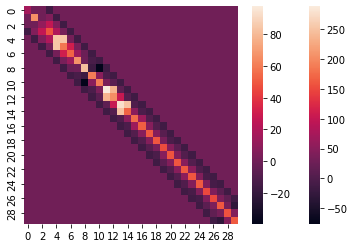

In [38]:
H =hessian(y, mu0, S0, A, B, ensemble_vars, E,plot = True)
sns.heatmap(H[:30,:30])

In [39]:
q = pupil_latent.to_numpy()
D.shape

(8, 8)

In [40]:
    
def kalman_newton_recursive(y, mu0, S0, A, B, ensemble_vars, E, f = None, df = None,df2 = None):
    """
    One-pass Kalman recursive method described in J. Humphrey et J. West, "Kalman filtering with Newton's method" 
    https://math.byu.edu/~jeffh/publications/papers/HW.pdf 
    
    
    """
    r = mu0.shape[0]
    T = y.shape[0]
    
    invE = np.linalg.inv(E)
    grad_z = dict.fromkeys(range(0, T))
    q = np.zeros((T,r))
    q[0,:] = mu0
    

    if f == None:
        print("Linear solve...")
        
        P = np.linalg.inv(S0) 
        for t in tqdm.tqdm(range(1,T-1)):
            D = np.diag(ensemble_vars[t])
            invD = np.linalg.inv(D)
            P = np.linalg.inv(np.linalg.inv(E+A@P@A.T)+B.T@invD@B)
            q[t,:] = A@q[t-1,:]-P@B.T@invD@(B@A@q[t-1,:]-y[t,:])   
            
        D = np.diag(ensemble_vars[T-1])
        invD = np.linalg.inv(D)
        P = np.linalg.inv(np.linalg.inv(E+A@P@A.T)+B.T@invD@B)
        q[T-1,:] = A@q[T-2,:]-P@B.T@invD@(B@A@q[T-2,:]-y[T-1,:])  

    return q
    


In [41]:
q_test =kalman_newton_recursive(y, mu0, S0, A, B, ensemble_vars, E, f = None, df = None,df2 = None)

Linear solve...


  0%|          | 0/1998 [00:00<?, ?it/s]

In [47]:
def latent_plots(q_test, q, mean_array,n=2000, **words):
    fig, ax = plt.subplots(3,1,figsize=(20,12))
    for i in range(3):
        ax[i].plot(q[:n,i], "-.",color="grey", label="reference eks")
        ax[i].plot(q_test[:,i]+mean_array[i], "--",color="green", label="newton eks")
    plt.legend()
    plt.suptitle("Kalman eks vs optimisation based latent predictions on pupil data")


In [51]:
q_test[:,1]+mean_array[1]

array([51.77925537, 54.88395953, 54.79162453, ..., 53.17031961,
       53.13198824, 53.16972497])

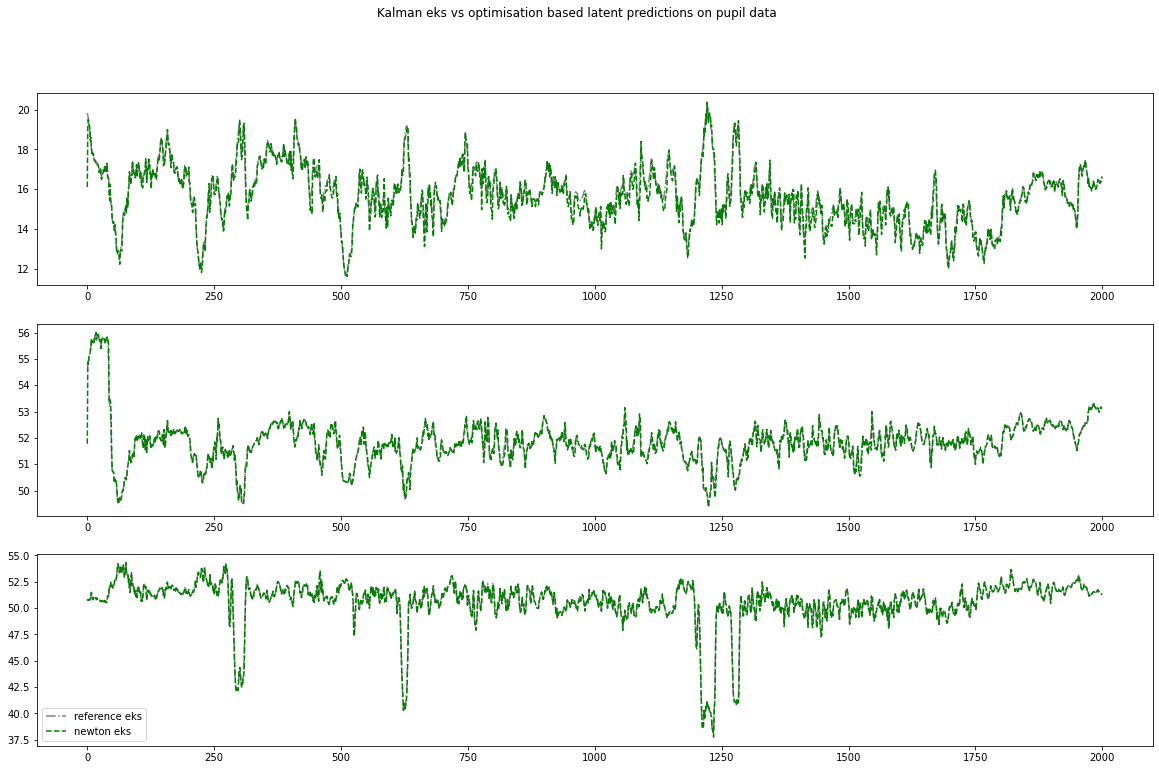

In [48]:
latent_plots(q_test,q,mean_array)

In [474]:
q_pred = np.zeros((T,r))
for i in range(r):
    q_pred[:,i] = q_test[:,i]+mean_array[i]

In [475]:
def get_likelihood(y, q, mu0, S0, A, B, ensemble_vars, E):
    invE = np.linalg.inv(E)
    loglik = np.zeros(T)
    loglik[0]= (q[:,0]-mu0).T @ np.linalg.inv(S0) @ (q[:,0]-mu0)
    r = mu0.shape[0]
    for k in range(1,y.shape[0]):
        D = np.diag(ensemble_vars[k])
        invD = np.linalg.inv(D)
        loglik[k] = (y[k,:]-B@q[:,k]).T@invD@(y[k,:]-B@q[:,k])
        + (q[:,k]-A@q[:,k-1]).T@invE@(q[:,k]-A@q[:,k-1])+loglik[k-1]
    plt.plot(loglik)
    return loglik
    

In [21]:
q_norm = np.zeros((T,r))
for i in range(r):
    q_norm[:,i] = q[:,i]-mean_array[i]
q_norm[:,0]=q[:,0]- mu0[0]
q_test[:,0]=q_test[:,0]- mu0[0]

NameError: name 'T' is not defined

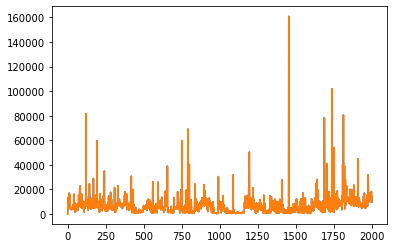

In [477]:
log1 = get_likelihood(y,q_test.T, mu0, S0, A, B, ensemble_vars, E)
log0 =  get_likelihood(y,q_norm.T, mu0, S0, A, B, ensemble_vars, E)

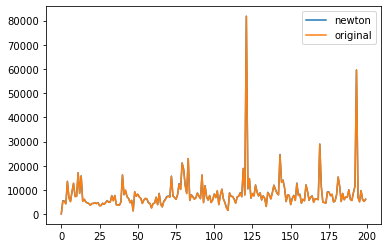

In [478]:
plt.plot(log1[:200], label="newton")
plt.plot(log0[:200],label="original")
plt.legend()

In [479]:
np.sum(log1-log0>0)/2000

0.745

In [540]:
def gradient2(q, y, mu0, S0, A, B, ensemble_vars, invE):
    T = y.shape[0]
    G = np.zeros((T,r))
    D = np.zeros((y.shape[1], y.shape[1]))
    G[0,:] = A.T @ invE @(q[1,:] - A @ q[0,:])+np.linalg.inv(S0)@(q[0,:]-mu0)+B.T@ np.linalg.inv(np.diag(ensemble_vars[0]))@(y[0,:]-B@q[0,:])
    
    for t in range(1,T-1):
        D = np.diag(ensemble_vars[t])
        invD = np.linalg.inv(D)
        G[t,:] = A.T @ invE@(q[t+1,:]-A@q[t,:]) - invE @(q[t,:]-A@q[t-1,:])+B.T @invD @(y[t,:]-B@q[t,:])
        #G[t,:] = (A.T @ invE @ A - invE + B.T @ invD @ B)@ q[t,:] - invE.T @A @ q[t-1,:] - A.T @ invE @ q[t+1,:] - B.T @ invD @y[t,:] 
    #G[T-1,:] = (A.T @ invE @ A - invE + B.T @ invD @ B)@ q[t,:] - invE.T @A @ q[t-1,:]  - B.T @ invD @y[t,:] 
    D = np.diag(ensemble_vars[T-1])
    invD = np.linalg.inv(D)
    G[T-1,:] =  - invE @(q[T-1,:]-A@q[T-2,:])+B.T @invD @(y[T-1,:]-B@q[T-1,:])
    
    return G

In [541]:
G_pred = gradient2(q_test, y, mu0, S0, A, B, ensemble_vars, invE)
G_o = gradient2(q_norm, y, mu0, S0, A, B, ensemble_vars, invE)

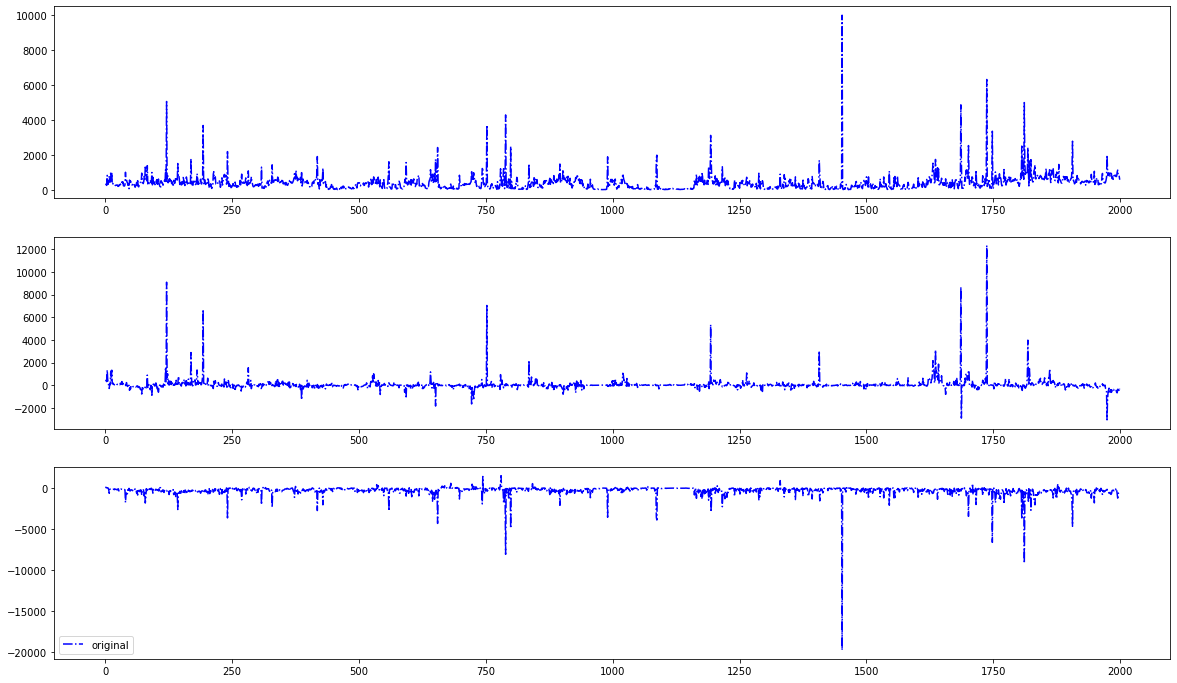

In [542]:
fig, ax = plt.subplots(3,1,figsize=(20,12))
for i in range(3):
    #ax[i].plot(G_pred[:,i], "r--", label='predicted')
    ax[i].plot(G_o[:,i], "b-.", label='original')
plt.legend()

In [534]:
No = np.linalg.norm(G_o,axis=0)
Npred = np.linalg.norm(G_pred,axis=0)

In [535]:
Npred, No

(array([27997.29997199, 25175.80336621, 33292.05167779]),
 array([129627.95663354, 496498.88286125, 628256.34491898]))

In [508]:
Npred-No

array([ 58.40602704, -11.09176658,  13.43382888])

Banded storage form: solveh_banded uses Thomas algorithm.
ab[u + i - j, j] == a[i,j] (if upper form; i <= j) ab[ i - j, j] == a[i,j] (if lower form; i >= j)
u number of upper diagonals.
 

In [509]:
n = H.shape[0]
lower_bandwidth = np.count_nonzero(H[1, :-1])
upper_bandwidth = np.count_nonzero(H[n-1,1:])

print(max([np.count_nonzero(H[i,i+1 :n//2]) for i in range(n)]), max([np.count_nonzero(H[i+1:n//2,i]) for i in range(n)]))

diagonals = [H.diagonal(offset=i) for i in range(-lower_bandwidth, upper_bandwidth+1)]
d = [d for d in diagonals if np.any(d)]
#v = [np.zeros(n - len(elem)) for elem in d]
print(d)

3 3
[array([-16.19376261, -16.19376261, -16.19376261, ..., -16.19376261,
       -64.96897151, -10.96833235]), array([  0.        ,   5.11524034,   5.11524034, ..., -76.13713977,
       -42.76679578, -42.76679578]), array([  0.        ,   0.        ,  26.18346041, ..., -23.86186704,
       -23.86186704,   0.        ]), array([ 16.35733597,  65.62522375,  11.07912358, ...,  70.29881582,
       288.32971385, 274.70240455]), array([  0.        ,   0.        ,  26.18346041, ..., -23.86186704,
       -23.86186704,   0.        ]), array([  0.        ,   5.11524034,   5.11524034, ..., -76.13713977,
       -42.76679578, -42.76679578]), array([-16.19376261, -16.19376261, -16.19376261, ..., -16.19376261,
       -64.96897151, -10.96833235])]


In [510]:
def convert_to_banded2(H):
    n = H.shape[0]
    l = max([np.count_nonzero(H[i,i+1 :n//2]) for i in range(n)])
    u = max([np.count_nonzero(H[i+1:n//2,i]) for i in range(n)])
    diagonals = [H.diagonal(offset=i) for i in range(-l, u+1)]
    d = [d for d in diagonals if np.any(d)]
    v = [np.zeros(n-len(elem)) for elem in d]
    AB = np.array([np.hstack([d[i],v[i]]) for i in range(len(d))])
    return AB, (l,u)

In [511]:
def convert_to_banded(H):
    n = H.shape[0]
    diagonals = [H.diagonal(offset=i) for i in range(H.shape[1])]
    d = [d for d in diagonals if np.any(d)]
    #print(d)
    v = [np.zeros(n-len(elem)) for elem in d]
    
    AB = np.array([np.hstack([d[i],v[i]]) for i in range(len(d))])
    return AB
#convert_to_banded(H)

<AxesSubplot:>

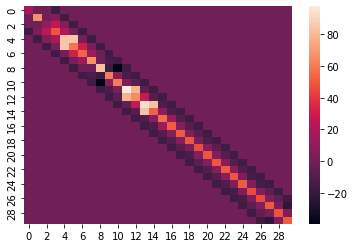

In [512]:
sns.heatmap(H[:30,:30])

In [513]:
ab = convert_to_banded(H)

In [514]:
def newton_eks_linear(y, mu0, S0, A, B, ensemble_vars, E, mode="banded", max_iter=200,plot=False):
    r = mu0.shape[0]
    T = y.shape[0]
    invE = np.linalg.inv(E)
    loss = []
    H = hessian(y, mu0, S0, A, B, ensemble_vars, E)
    q = np.zeros((T,r))
    loss = np.zeros(max_iter)
    qnew = np.zeros((T,r))
    if mode=="banded":
        ab, pos = convert_to_banded2(H)
        for iter in range(max_iter):
            #qnew = sp.linalg.solveh_banded(ab,G,lower=True)
            #qnew = sp.linalg.solve_banded(pos, ab, G)
            for i in range(r):
                G = gradient2(q, y, mu0, S0, A, B, ensemble_vars, invE)
                qnew[:,i] = q[:,i] + sp.linalg.solve_banded(pos,ab, G[:,i])
            loss[iter] += np.linalg.norm(qnew-q,2)
            q = qnew
    elif mode=="linalg.inv":
        for iter in range(max_iter):
            G = gradient2(q, y, mu0, S0, A, B, ensemble_vars, invE)
            qnew = q - np.linalg.inv(H)@G
            loss[iter] += np.linalg.norm(qnew-q,2)
            q = qnew
    elif mode=="recursive":
        q = kalman_newton_recursive(y, mu0, S0, A, B, ensemble_vars, E)
    elif mode=="linalg.solve":
        for iter in range(max_iter): 
            G = gradient2(q, y, mu0, S0, A, B, ensemble_vars, invE)
            qnew = q - np.linalg.solve(H,G) 
                #q[:,i] = qnew[:,i]
            loss[iter] += np.linalg.norm(qnew-q,2)
            q = qnew
    if plot:
        plt.plot(loss)
    return q,loss

  0%|          | 0/1997 [00:00<?, ?it/s]

Hessian


  0%|          | 0/1997 [00:00<?, ?it/s]

Hessian


  0%|          | 0/1997 [00:00<?, ?it/s]

Hessian


  0%|          | 0/1997 [00:00<?, ?it/s]

Hessian
Linear solve...


  0%|          | 0/1998 [00:00<?, ?it/s]

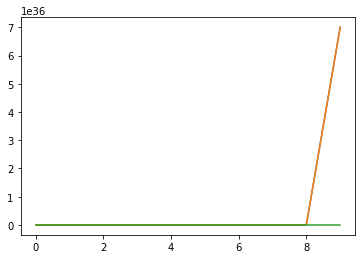

In [515]:
q1, loss = newton_eks_linear(y, mu0, S0, A, B, ensemble_vars, E, mode="linalg.solve", max_iter=10, plot=True)
q2, loss = newton_eks_linear(y, mu0, S0, A, B, ensemble_vars, E, mode="linalg.inv", max_iter=10, plot=True)
q3, loss = newton_eks_linear(y, mu0, S0, A, B, ensemble_vars, E, mode="banded", max_iter=10, plot=True)
q4, loss = newton_eks_linear(y, mu0, S0, A, B, ensemble_vars, E, mode="recursive")

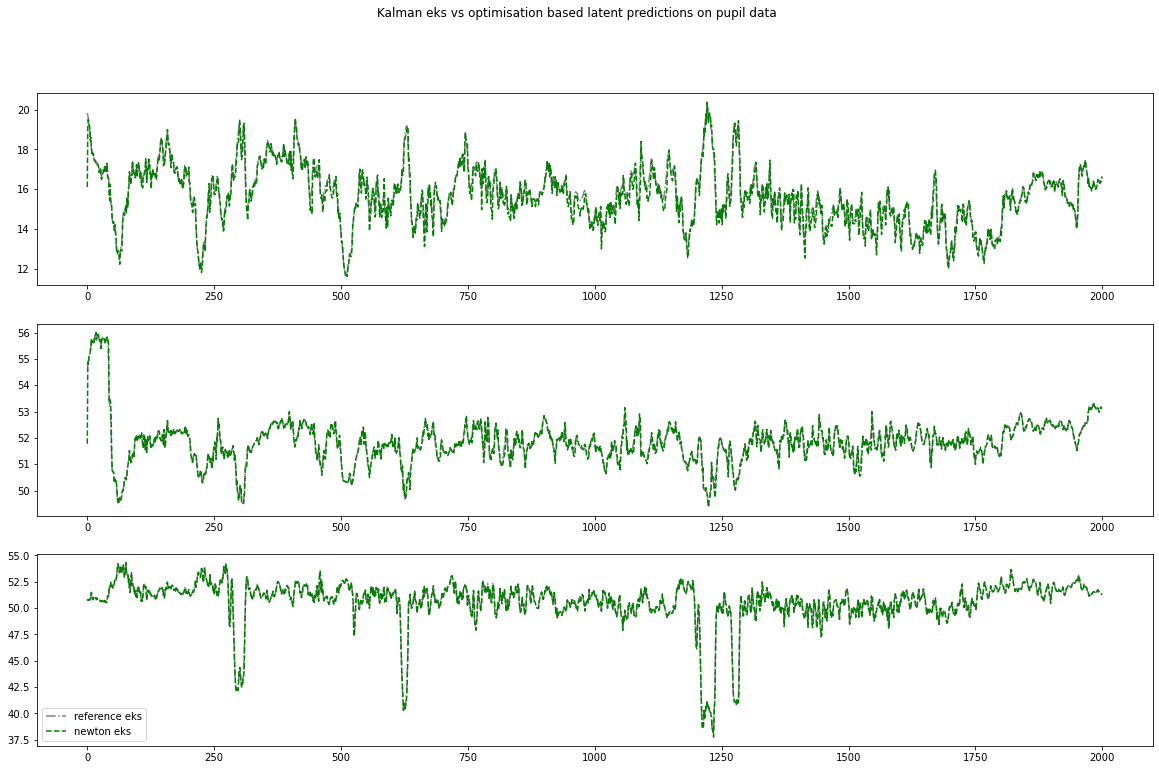

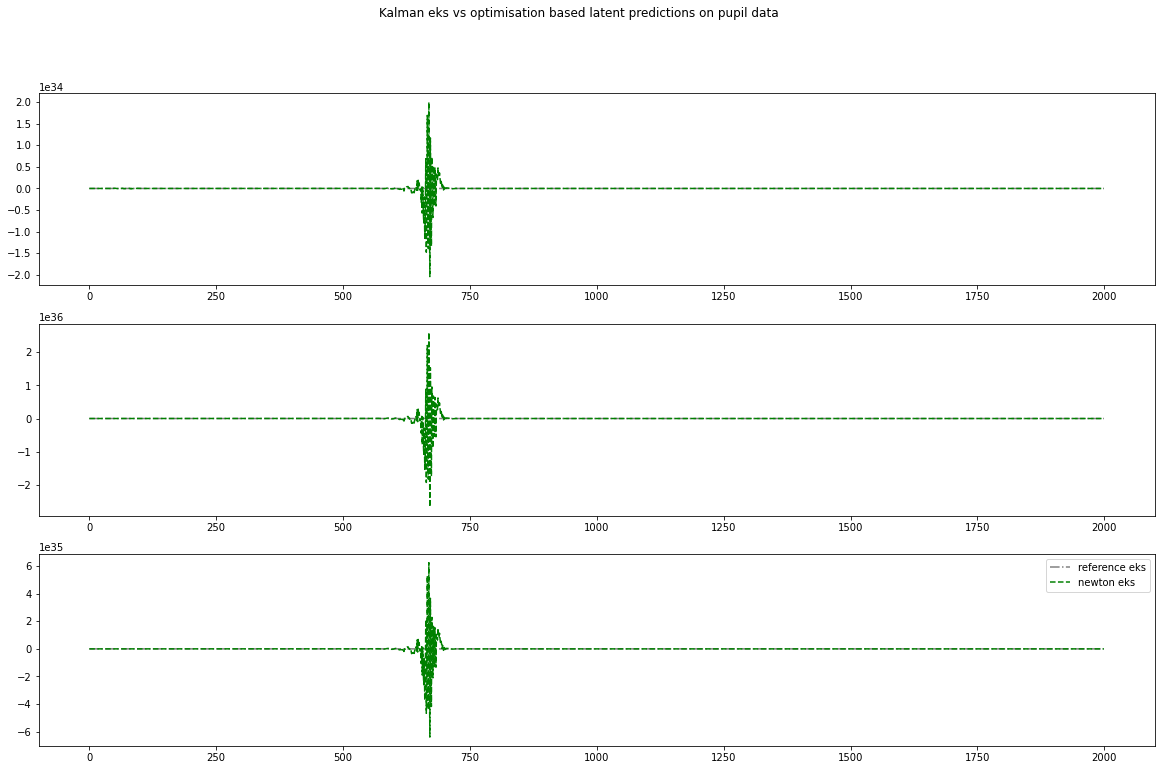

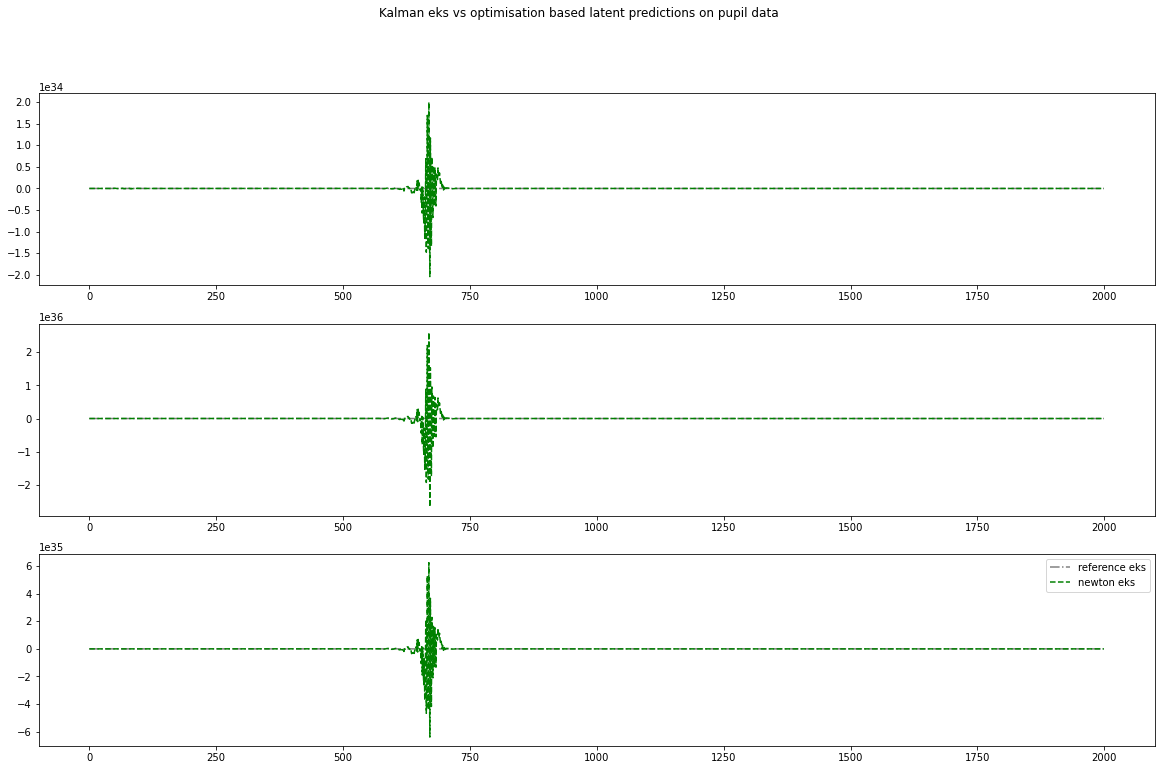

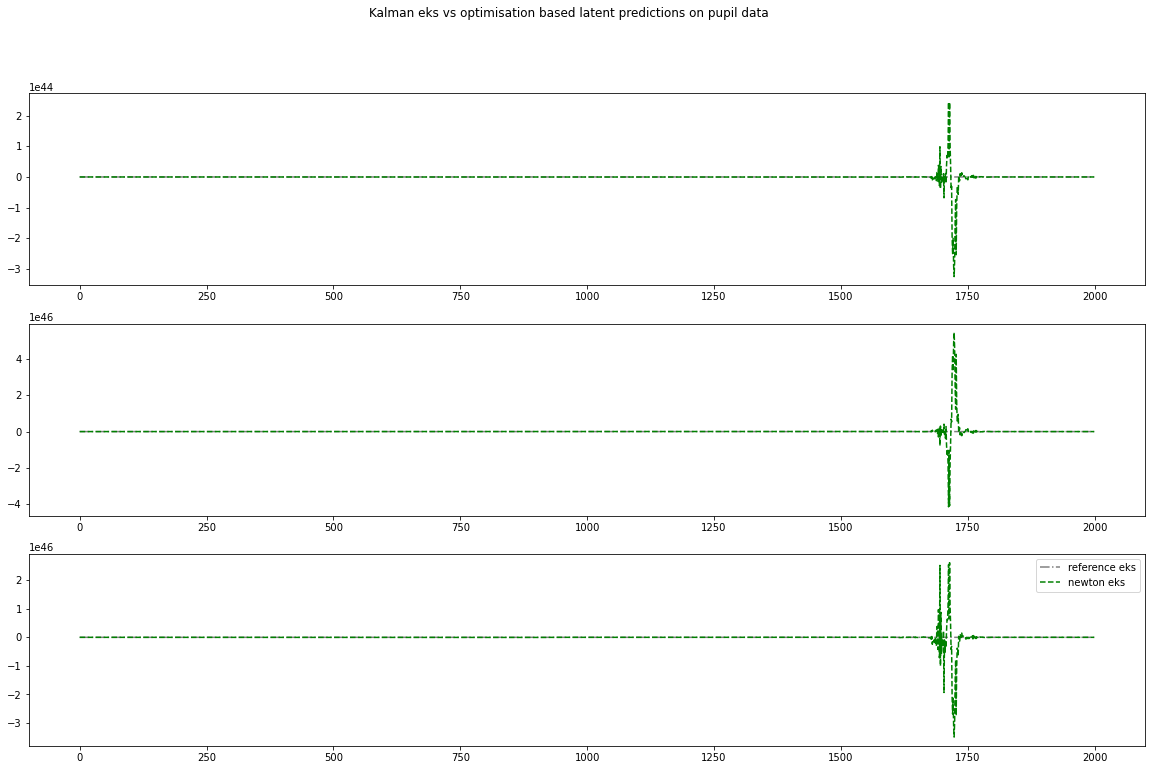

In [516]:
n=2000
latent_plots(q4[:n,:],q, n)
latent_plots(q1[:n,:],q, n)
latent_plots(q2[:n,:],q, n)
latent_plots(q3[:n,:],q, n)

In [517]:
q_1 = newton_eks_linear(y, mu0, S0, A, B, D, E, mode="linalg.inv")
q_2 = newton_eks_linear(y, mu0, S0, A, B, D, E, mode="recursive")
q_4 = newton_eks_linear(y, mu0, S0, A, B, D, E, mode="linalg.solve")
q_3 = newton_eks_linear(y, mu0, S0, A, B, D, E, mode="linalg.banded")

  0%|          | 0/1997 [00:00<?, ?it/s]

LinAlgError: Singular matrix

In [315]:
convert_banded(

SyntaxError: unexpected EOF while parsing (288090467.py, line 1)

In [310]:
n=2000
latent_plots(q_4[:n,:],q, n)
latent_plots(q_1[:n,:],q, n)
latent_plots(q_2[:n,:],q, n)
latent_plots(q_3[:n,:],q, n)

NameError: name 'q_4' is not defined

In [214]:
q_3[:,1].shape

NameError: name 'q_3' is not defined

In [ ]:
mean_array

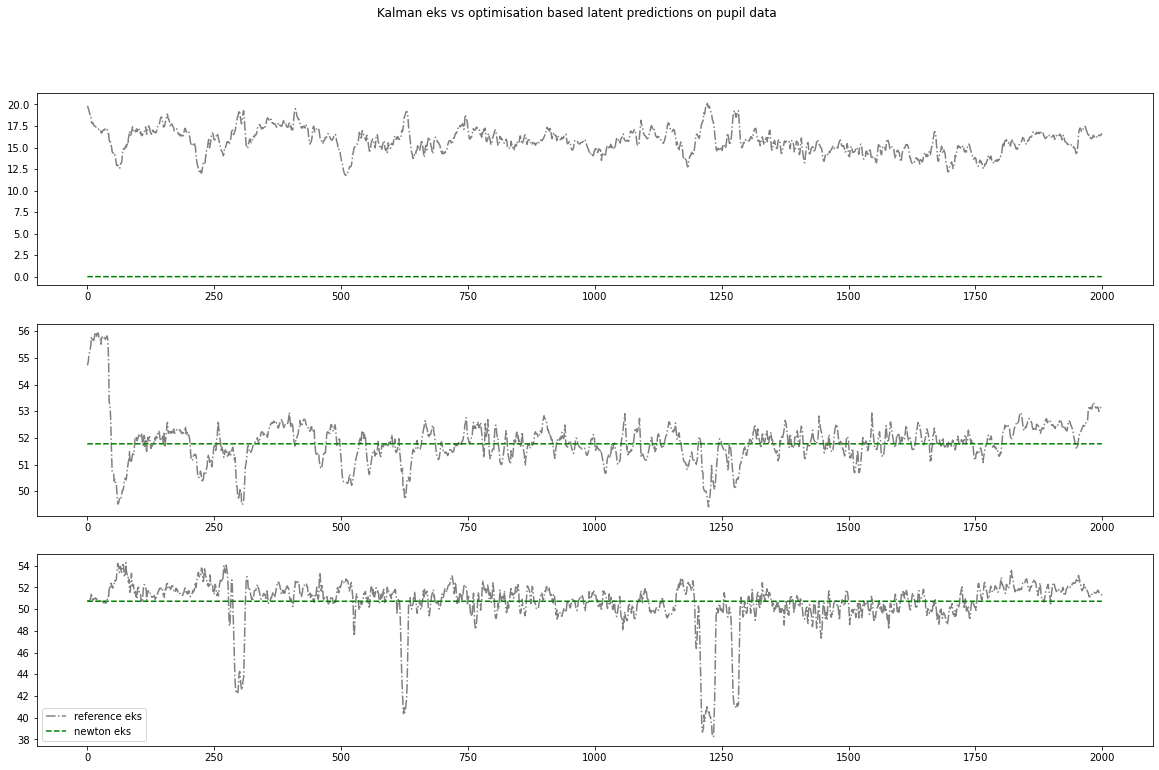

In [260]:
latent_plots(q3[:n,:],q, n)

# Simulations

In [ ]:
np.random.seed(88)
n = 8
r = 3
T = 100

mu0 = np.asarray([0.0, 0.0, 0.0])

# diagonal: var
S0 = np.asarray([
    [a, 0.0, 0.0],
    [0.0, b, 0.0],
    [0.0, 0.0, c]
])

A = np.asarray([
    [0.99, 0, 0],
    [0, 0.99, 0],
    [0, 0, 0.99]
])
B = np.asarray([[0, 1, 0], [-.5, 0, 1], [0, 1, 0], 
                [.5, 0, 1], [.5, 1, 0], [0, 0, 1], 
                [-.5, 1, 0],[0, 0, 1]])

# state covariance matrix
E = np.asarray([
        [a * (1 - (A[0, 0] ** 2)), 0, 0],
        [0, b * (1 - A[1, 1] ** 2), 0],
        [0, 0, c * (1 - (A[2, 2] ** 2))]
    ])

D = np.eye(8)

q = np.zeros((T,r))
y = np.zeros((T,n))
q[0,:] = np.random.multivariate_normal(mu0, S0)
y[0,:] = np.random.multivariate_normal(B@q[0,:], D)
for i in range(1,T):
    q[i,:] = np.random.multivariate_normal(A@q[i-1,:], E)
    y[i,:] = np.random.multivariate_normal(B@q[i,:], D)


In [ ]:
for i in range(r):
    plt.plot(q[:,i])

In [ ]:
for i in range(n):
    plt.plot(y[:,i])

In [ ]:
q1 =newton_eks_linear(y, mu0, S0, A,B,D,E, mode="linalg.solve")
q2 =newton_eks_linear(y, mu0, S0, A,B,D,E, mode="linalg.inv")
q4 =newton_eks_linear(y, mu0, S0, A,B,D,E, mode="recursive")
q3 =newton_eks_linear(y, mu0, S0, A,B,D,E, mode="banded")

In [ ]:
n=2000
latent_plots(q4[:n,:], q,n)
latent_plots(q1[:n,:], q,n)
latent_plots(q2[:n,:], q,n)
latent_plots(q3[:n,:], q,n)

Ax = b, 

In [440]:
A = np.array([[1, -1, 0, 0, 0, 0],
             [-1, 1, -1, 0, 0, 0],
             [0, -1, 1, -1, 0, 0],
             [0, 0, -1, 1, -1, 0],
             [0, 0, 0, -1, 1, -1],
             [0, 0, 0, 0, -1, 1]])
b = np.array([1, 1, 1, 0, 0, 0])

In [443]:
ab, pos = convert_to_banded2(A)
print(ab)

[[-1. -1. -1. -1. -1.  0.]
 [ 1.  1.  1.  1.  1.  1.]
 [-1. -1. -1. -1. -1.  0.]]


In [444]:
x = sp.linalg.solve_banded(pos, ab, b)

LinAlgError: singular matrix

Smoothing matrix: [[0.99 0.   0.  ]
 [0.   0.99 0.  ]
 [0.   0.   0.99]]
Linear solve...


  0%|          | 0/1998 [00:00<?, ?it/s]

saving smoothed predictions to data/misc/pupil-test/opti/opti_eks_pupil_traces.csv
saving latents to data/misc/pupil-test/opti/opti_eks_latents.csv


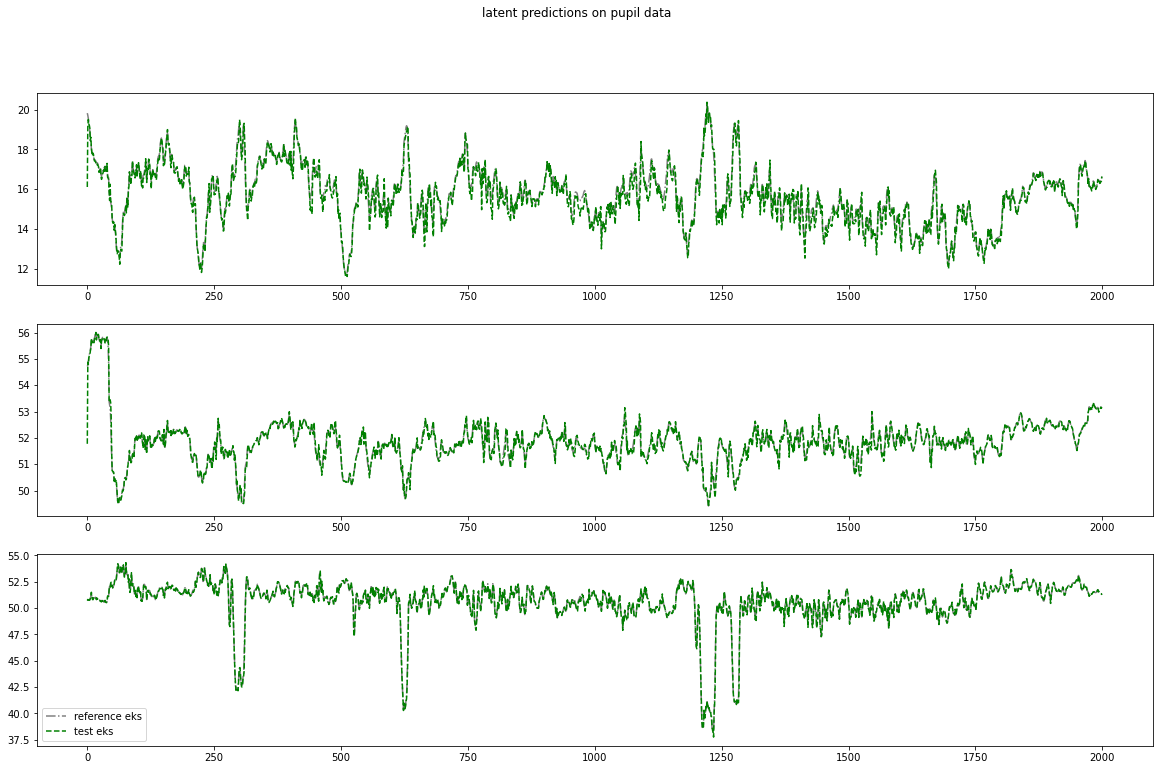

In [4]:
%run -i 'scripts/optimisation_example.py'  --csv-dir 'data/ibl-pupil' --save-dir 'data/misc/pupil-test/opti/' --diameter-s 0.99 --com-s 0.99 

In [18]:
mean_array=np.array([0, mean_x_obs])
mean_array[0]

0.0

# Fish

In [36]:
%run -i "test_script.py"

filtering head...
done filtering
smoothing head...
done smoothing
filtering chin_base...
done filtering
smoothing chin_base...
done smoothing
filtering chin1_4...
done filtering
smoothing chin1_4...
done smoothing
filtering chin_half...
done filtering
smoothing chin_half...
done smoothing
filtering chin3_4...
done filtering
smoothing chin3_4...
done smoothing
filtering chin_tip...
done filtering
smoothing chin_tip...
done smoothing
filtering mid...
done filtering
smoothing mid...
done smoothing
filtering fork...
done filtering
smoothing fork...
done smoothing
filtering stripeA...
done filtering
smoothing stripeA...
done smoothing
filtering stripeP...
done filtering
smoothing stripeP...
done smoothing
filtering tail_neck...
done filtering
smoothing tail_neck...
done smoothing
filtering dorsal...
done filtering
smoothing dorsal...
done smoothing
filtering anal...
done filtering
smoothing anal...
done smoothing
filtering caudal_d...
done filtering
smoothing caudal_d...
done smoothing
filt

NotADirectoryError: [Errno 20] Not a directory: '/Users/clairehe/Documents/GitHub/eks/data/misc/mirror-fish_ensemble-predictions/network_0/.DS_Store'

In [41]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from sklearn.decomposition import PCA
from eks.utils import make_dlc_pandas_index
from eks.ensemble_kalman import ensemble, filtering_pass, kalman_dot, smooth_backward

def remove_camera_means(ensemble_stacks, camera_means):
    scaled_ensemble_stacks = ensemble_stacks.copy()
    for k in range(len(ensemble_stacks)):
        for camera_id, camera_mean in enumerate(camera_means):
            scaled_ensemble_stacks[k][:,camera_id] = ensemble_stacks[k][:,camera_id] - camera_mean
    return scaled_ensemble_stacks


def add_camera_means(ensemble_stacks, camera_means):
    scaled_ensemble_stacks = ensemble_stacks.copy()
    for k in range(len(ensemble_stacks)):
        for camera_id, camera_mean in enumerate(camera_means):
            scaled_ensemble_stacks[k][:,camera_id] = ensemble_stacks[k][:,camera_id] + camera_mean
    return scaled_ensemble_stacks


def pca(S, n_comps):
    pca_ = PCA(n_components=n_comps)
    return pca_.fit(S), pca_.explained_variance_ratio_


# -----------------------
# funcs for mirror-mouse
# -----------------------
def eks_opti_smoother_multi_cam(
        markers_list_cameras, keypoint_ensemble, smooth_param, quantile_keep_pca, camera_names):
    """Use multi-view constraints to fit a 3d latent subspace for each body part.

    Parameters
    ----------
    markers_list_cameras : list of list of pd.DataFrames
        each list element is a list of dataframe predictions from one ensemble member for each camera.
    keypoint_ensemble : str
        the name of the keypoint to be ensembled and smoothed
    smooth_param : float
        ranges from .01-2 (smaller values = more smoothing)
    quantile_keep_pca
        percentage of the points are kept for multi-view PCA (lowest ensemble variance)
    camera_names: list
        the camera names (should be the same length as markers_list_cameras).

    Returns
    -------

    Returns
    -------
    dict
        markers_df: dataframe containing smoothed markers; same format as input dataframes
        latents_df: dataframe containing 3d latents: multiview PCA

    """

    # --------------------------------------------------------------
    # interpolate right cam markers to left cam timestamps
    # --------------------------------------------------------------
    num_cameras = len(camera_names)
    markers_list_stacked_interp = []
    markers_list_interp = [[] for i in range(num_cameras)]
    for model_id in range(len(markers_list_cameras[0])):
        bl_markers_curr = []
        camera_markers_curr = [[] for i in range(num_cameras)]
        for i in range(markers_list_cameras[0][0].shape[0]):
            curr_markers = []
            for camera in range(num_cameras):
                markers = np.array(markers_list_cameras[camera][model_id].to_numpy()[i, [0, 1]])
                camera_markers_curr[camera].append(markers)
                curr_markers.append(markers)
            bl_markers_curr.append(np.concatenate(curr_markers)) #combine predictions for both cameras
        markers_list_stacked_interp.append(bl_markers_curr)
        for camera in range(num_cameras):
            markers_list_interp[camera].append(camera_markers_curr[camera])
    markers_list_stacked_interp = np.asarray(markers_list_stacked_interp)
    markers_list_interp = np.asarray(markers_list_interp)
    
    keys = [keypoint_ensemble+'_x', keypoint_ensemble+'_y']
    markers_list_cams = [[] for i in range(num_cameras)]
    for k in range(len(markers_list_interp[0])):
        for camera in range(num_cameras):
            markers_cam = pd.DataFrame(markers_list_interp[camera][k], columns = keys)
            markers_list_cams[camera].append(markers_cam)
            
    #compute ensemble median for each camera
    cam_ensemble_preds = []
    cam_ensemble_vars = []
    cam_ensemble_stacks = []
    cam_keypoints_mean_dict = []
    cam_keypoints_var_dict = []
    cam_keypoints_stack_dict = []
    for camera in range(num_cameras):
        cam_ensemble_preds_curr, cam_ensemble_vars_curr, cam_ensemble_stacks_curr, cam_keypoints_mean_dict_curr, cam_keypoints_var_dict_curr, cam_keypoints_stack_dict_curr = ensemble(markers_list_cams[camera], keys)
        cam_ensemble_preds.append(cam_ensemble_preds_curr)
        cam_ensemble_vars.append(cam_ensemble_vars_curr)
        cam_ensemble_stacks.append(cam_ensemble_stacks_curr)
        cam_keypoints_mean_dict.append(cam_keypoints_mean_dict_curr)
        cam_keypoints_var_dict.append(cam_keypoints_var_dict_curr)
        cam_keypoints_stack_dict.append(cam_keypoints_stack_dict_curr)
        
    #filter by low ensemble variances
    hstacked_vars = np.hstack(cam_ensemble_vars)
    max_vars = np.max(hstacked_vars,1)
    quantile_keep = quantile_keep_pca
    good_frames = np.where(max_vars <= np.percentile(max_vars, quantile_keep))[0]

    good_cam_ensemble_preds = []
    good_cam_ensemble_vars = []
    for camera in range(num_cameras):
        good_cam_ensemble_preds.append(cam_ensemble_preds[camera][good_frames])
        good_cam_ensemble_vars.append(cam_ensemble_vars[camera][good_frames])

    good_ensemble_preds = np.hstack(good_cam_ensemble_preds)
    good_ensemble_vars = np.hstack(good_cam_ensemble_vars)
    means_camera = []
    for i in range(good_ensemble_preds.shape[1]):
        means_camera.append(good_ensemble_preds[:,i].mean())

    ensemble_preds = np.hstack(cam_ensemble_preds)
    ensemble_vars = np.hstack(cam_ensemble_vars)
    ensemble_stacks = np.concatenate(cam_ensemble_stacks,2)
    scaled_ensemble_stacks = remove_camera_means(ensemble_stacks, means_camera)

    good_scaled_ensemble_preds = remove_camera_means(good_ensemble_preds[None,:,:], means_camera)[0]
    ensemble_pca, ensemble_ex_var = pca(good_scaled_ensemble_preds, 3)

    scaled_ensemble_preds = remove_camera_means(ensemble_preds[None,:,:], means_camera)[0]
    ensemble_pcs = ensemble_pca.transform(scaled_ensemble_preds)
    good_ensemble_pcs = ensemble_pcs[good_frames]

    y_obs = scaled_ensemble_preds
    
    #compute center of mass
    #latent variables (observed)
    good_z_t_obs = good_ensemble_pcs #latent variables - true 3D pca

    ##### Set values for kalman filter #####
    m0 = np.asarray([0.0, 0.0, 0.0]) # initial state: mean
    S0 =  np.asarray([[np.var(good_z_t_obs[:,0]), 0.0, 0.0], [0.0, np.var(good_z_t_obs[:,1]), 0.0], [0.0, 0.0, np.var(good_z_t_obs[:,2])]]) # diagonal: var

    A = np.asarray([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]) #state-transition matrix,
    # Q = np.asarray([[10.0, 0.0, 0.0], [0.0, 10.0, 0.0], [0.0, 0.0, 10.0]]) #state covariance matrix?????
    d_t = good_z_t_obs[1:] - good_z_t_obs[:-1]

    E = smooth_param*np.cov(d_t.T)

    B = ensemble_pca.components_.T # Measurement function is inverse transform of PCA
    D = np.eye(ensemble_pca.components_.shape[1]) # placeholder diagonal matrix for ensemble variance
    
    # --------------------------------------
    # Run EKS opti
    # --------------------------------------
    ms = kalman_newton_recursive(y_obs, m0, S0, A, B, ensemble_vars, E)

    # Smoothed posterior over y
    y_m_smooth = np.dot(B, ms.T).T


    # --------------------------------------
    # final cleanup
    # --------------------------------------
    pdindex = make_dlc_pandas_index([keypoint_ensemble])
    camera_indices = []
    for camera in range(num_cameras):
        camera_indices.append([camera*2, camera*2+1])
 
    camera_dfs = {}
    for camera, camera_name in enumerate(camera_names):
        var = np.empty(y_m_smooth.T[camera_indices[camera][0]].shape)
        var[:] = np.nan
        pred_arr = np.vstack([
            y_m_smooth.T[camera_indices[camera][0]] + means_camera[camera_indices[camera][0]],
            y_m_smooth.T[camera_indices[camera][1]] + means_camera[camera_indices[camera][1]],
            var,
        ]).T
        camera_dfs[camera_name + '_df'] = pd.DataFrame(pred_arr, columns=pdindex)

    return camera_dfs


In [42]:
import os
import pandas as pd
import numpy as np
import sys

#%%%%%%%%%% Set paths, requirements

#os.chdir('/Users/clairehe/Documents/GitHub/eks/')
#print(os.getcwd())
#!pip install -r requirements.txt
#!pip install -e .

#%%%%%%%%%%

from eks.utils import convert_lp_dlc
from eks.multiview_pca_smoother import ensemble_kalman_smoother_multi_cam


camera_names = ['main', 'top', 'right']
keypoint_ensemble_list = [
    'head', 'chin_base', 'chin1_4', 'chin_half','chin3_4', 'chin_tip', 'mid', 'fork',
    'stripeA', 'stripeP', 'tail_neck', 'dorsal', 'anal', 'caudal_d', 'caudal_v',
]
tracker_name = 'heatmap_mhcrnn_tracker'
num_cameras = len(camera_names)

# NOTE! replace this path with an absolute path where you want to save EKS outputs
eks_save_dir = '/Users/clairehe/Documents/GitHub/eks/data/misc/one-video-mirror-fish-predictions/eks_opti/'

# path for prediction csvs
file_path = '/Users/clairehe/Documents/GitHub/eks/data/misc/mirror-fish_ensemble-predictions'

# NOTE! replace these paths with the absolute paths to prediction csvs on your local computer
model_dirs = [
    file_path+"/network_0",
    file_path+"/network_1",
    file_path+"/network_2",
    file_path+"/network_3",
    file_path+"/network_4",
]

sessions = os.listdir(model_dirs[0])
for session in sessions:
    frames = os.listdir(os.path.join(model_dirs[0], session))
    for frame in frames:
        #print(frame)
        # extract all markers
        markers_list = []
        for model_dir in model_dirs:
            csv_file = os.path.join(model_dir, session, frame)
            df_tmp = pd.read_csv(csv_file, header=[0, 1, 2], index_col=0)
            keypoint_names = [l[1] for l in df_tmp.columns[::3]]
            markers_tmp = convert_lp_dlc(df_tmp, keypoint_names, model_name=tracker_name)
            markers_list.append(markers_tmp)
        # make empty dataframe to write results into
        df_eks = df_tmp.copy()
        for col in df_eks.columns:
            if col[-1] == 'likelihood':
                df_eks[col].values[:] = 1.0
            else:
                df_eks[col].values[:] = np.nan
        # fit kalman on a keypoint-by-keypoint basis
        for keypoint_ensemble in keypoint_ensemble_list:
            markers_list_cameras = [[] for i in range(num_cameras)]
            for m in markers_list:
                for camera in range(num_cameras):
                    markers_list_cameras[camera].append(
                        m[[key for key in m.keys() 
                           if camera_names[camera] in key 
                           and 'likelihood' not in key 
                           and keypoint_ensemble in key]
                         ]
                    )
            cameras_df = eks_opti_smoother_multi_cam(
                markers_list_cameras=markers_list_cameras, 
                keypoint_ensemble=keypoint_ensemble, 
                smooth_param=0.01,
                quantile_keep_pca=50, 
                camera_names=camera_names,
            )
            # put results into new dataframe
            for camera in camera_names:
                df_tmp = cameras_df[f'{camera}_df']
                for coord in ['x', 'y']:
                    src_cols = ('ensemble-kalman_tracker', f'{keypoint_ensemble}', coord)
                    dst_cols = (tracker_name, f'{keypoint_ensemble}_{camera}', coord)
                    df_eks.loc[:, dst_cols] = df_tmp.loc[:, src_cols]
        # save eks results
        save_dir = os.path.join(eks_save_dir, session)
        os.makedirs(save_dir, exist_ok=True)
        df_eks.to_csv(os.path.join(save_dir, frame))

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

Linear solve...


  0%|          | 0/49 [00:00<?, ?it/s]

NotADirectoryError: [Errno 20] Not a directory: '/Users/clairehe/Documents/GitHub/eks/data/misc/mirror-fish_ensemble-predictions/network_0/.DS_Store'

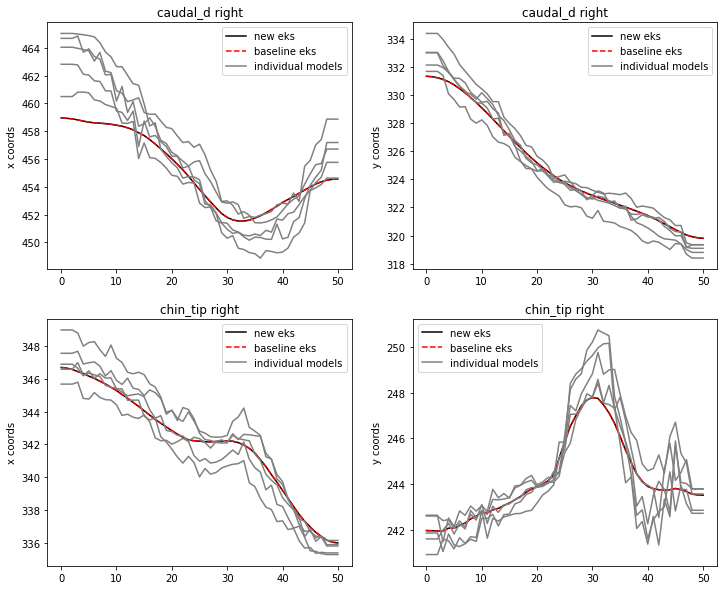

In [43]:
baseline = pd.read_csv("/Users/clairehe/Documents/GitHub/eks/data/misc/mirror-fish_ensemble-predictions/eks/20210204_Quin/img197707.csv", header=[ 1, 2],index_col=0)
new = pd.read_csv("/Users/clairehe/Documents/GitHub/eks/data/misc/one-video-mirror-fish-predictions/eks_outputs/20210204_Quin/img197707.csv", header=[ 1, 2], index_col=0)
baseline0 = pd.read_csv("/Users/clairehe/Documents/GitHub/eks/data/misc/mirror-fish_ensemble-predictions/eks/20210204_Quin/img197707.csv", header=[0, 1, 2],index_col=0)

keypoint_names = [l[1] for l in baseline0.columns[::3]]
markers_tmp = convert_lp_dlc(baseline0, keypoint_names, model_name=tracker_name)
markers_tmp.head()

pathfile = "/Users/clairehe/Documents/GitHub/eks/data/misc/mirror-fish_ensemble-predictions/"

fig,ax = plt.subplots(2,2,figsize=(12,10))

ax[0,0].plot(new.caudal_d_right[["x"]], color='black')
ax[0,0].plot(baseline.caudal_d_right[["x"]], 'r--',label='baseline' )
ax[0,0].plot(pd.read_csv(pathfile+"network_0"+"/20210204_Quin/img197707.csv", header=[1,2]).caudal_d_right[["x"]], color='gray')
ax[0,0].plot(pd.read_csv(pathfile+"network_1"+"/20210204_Quin/img197707.csv", header=[1,2]).caudal_d_right[["x"]], color='gray')
ax[0,0].plot(pd.read_csv(pathfile+"network_2"+"/20210204_Quin/img197707.csv", header=[1,2]).caudal_d_right[["x"]], color='gray')
ax[0,0].plot(pd.read_csv(pathfile+"network_3"+"/20210204_Quin/img197707.csv", header=[1,2]).caudal_d_right[["x"]], color='gray')
ax[0,0].plot(pd.read_csv(pathfile+"network_4"+"/20210204_Quin/img197707.csv", header=[1,2]).caudal_d_right[["x"]], color='gray')
ax[0,0].set_ylabel("x coords")
ax[0,0].set_title("caudal_d right")
ax[0,0].legend(['new eks','baseline eks', 'individual models'])

ax[0,1].plot(new.caudal_d_right[["y"]], color='black')
ax[0,1].plot(baseline.caudal_d_right[["y"]], 'r--',label='baseline')
ax[0,1].plot(pd.read_csv(pathfile+"network_0"+"/20210204_Quin/img197707.csv", header=[1,2]).caudal_d_right[["y"]], color='gray')
ax[0,1].plot(pd.read_csv(pathfile+"network_1"+"/20210204_Quin/img197707.csv", header=[1,2]).caudal_d_right[["y"]], color='gray')
ax[0,1].plot(pd.read_csv(pathfile+"network_2"+"/20210204_Quin/img197707.csv", header=[1,2]).caudal_d_right[["y"]], color='gray')
ax[0,1].plot(pd.read_csv(pathfile+"network_3"+"/20210204_Quin/img197707.csv", header=[1,2]).caudal_d_right[["y"]], color='gray')
ax[0,1].plot(pd.read_csv(pathfile+"network_4"+"/20210204_Quin/img197707.csv", header=[1,2]).caudal_d_right[["y"]], color='gray')
ax[0,1].set_title("caudal_d right")
ax[0,1].set_ylabel("y coords")
ax[0,1].legend(['new eks','baseline eks', 'individual models'])

ax[1,0].plot(new.chin_tip_right[["x"]], color='black')
ax[1,0].plot(baseline.chin_tip_right[["x"]], 'r--',label='baseline')
ax[1,0].plot(pd.read_csv(pathfile+"network_0"+"/20210204_Quin/img197707.csv", header=[1,2]).chin_tip_right[["x"]], color='gray')
ax[1,0].plot(pd.read_csv(pathfile+"network_1"+"/20210204_Quin/img197707.csv", header=[1,2]).chin_tip_right[["x"]], color='gray')
ax[1,0].plot(pd.read_csv(pathfile+"network_2"+"/20210204_Quin/img197707.csv", header=[1,2]).chin_tip_right[["x"]], color='gray')
ax[1,0].plot(pd.read_csv(pathfile+"network_3"+"/20210204_Quin/img197707.csv", header=[1,2]).chin_tip_right[["x"]], color='gray')
ax[1,0].plot(pd.read_csv(pathfile+"network_4"+"/20210204_Quin/img197707.csv", header=[1,2]).chin_tip_right[["x"]], color='gray')
ax[1,0].set_title("chin_tip right")
ax[1,0].set_ylabel("x coords")
ax[1,0].legend(['new eks','baseline eks', 'individual models'])

ax[1,1].plot(new.chin_tip_right[["y"]],color='black')
ax[1,1].plot(baseline.chin_tip_right[["y"]], 'r--',label='baseline')
ax[1,1].plot(pd.read_csv(pathfile+"network_0"+"/20210204_Quin/img197707.csv", header=[1,2]).chin_tip_right[["y"]], color='gray')
ax[1,1].plot(pd.read_csv(pathfile+"network_1"+"/20210204_Quin/img197707.csv", header=[1,2]).chin_tip_right[["y"]], color='gray')
ax[1,1].plot(pd.read_csv(pathfile+"network_2"+"/20210204_Quin/img197707.csv", header=[1,2]).chin_tip_right[["y"]], color='gray')
ax[1,1].plot(pd.read_csv(pathfile+"network_3"+"/20210204_Quin/img197707.csv", header=[1,2]).chin_tip_right[["y"]], color='gray')
ax[1,1].plot(pd.read_csv(pathfile+"network_4"+"/20210204_Quin/img197707.csv", header=[1,2]).chin_tip_right[["y"]], color='gray')
ax[1,1].set_title("chin_tip right")
ax[1,1].set_ylabel("y coords")
ax[1,1].legend(['new eks','baseline eks', 'individual models'])


Text(0.5, 0.98, 'Video 197707')

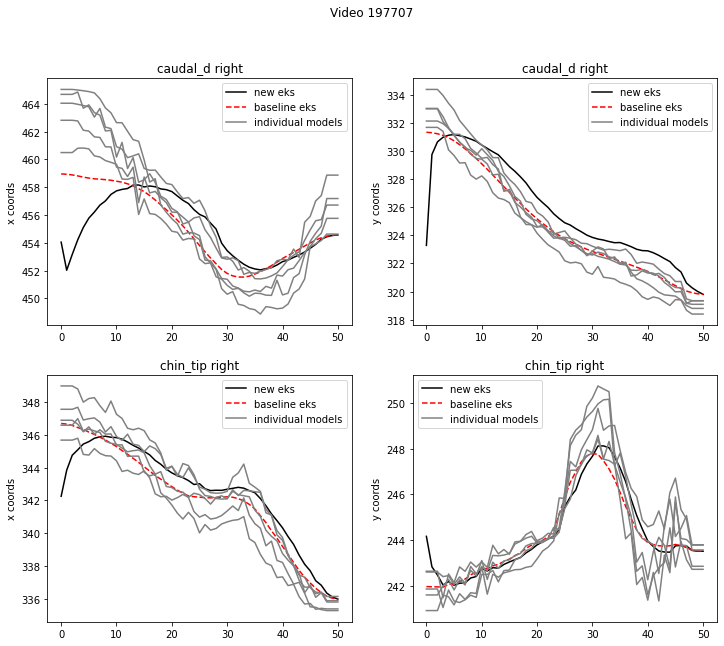

In [44]:
baseline = pd.read_csv("/Users/clairehe/Documents/GitHub/eks/data/misc/mirror-fish_ensemble-predictions/eks/20210204_Quin/img197707.csv", header=[ 1, 2],index_col=0)
new = pd.read_csv("/Users/clairehe/Documents/GitHub/eks/data/misc/one-video-mirror-fish-predictions/eks_opti/20210204_Quin/img197707.csv", header=[ 1, 2], index_col=0)
baseline0 = pd.read_csv("/Users/clairehe/Documents/GitHub/eks/data/misc/mirror-fish_ensemble-predictions/eks/20210204_Quin/img197707.csv", header=[0, 1, 2],index_col=0)

keypoint_names = [l[1] for l in baseline0.columns[::3]]
markers_tmp = convert_lp_dlc(baseline0, keypoint_names, model_name=tracker_name)
markers_tmp.head()

pathfile = "/Users/clairehe/Documents/GitHub/eks/data/misc/mirror-fish_ensemble-predictions/"

fig,ax = plt.subplots(2,2,figsize=(12,10))

ax[0,0].plot(new.caudal_d_right[["x"]], color='black')
ax[0,0].plot(baseline.caudal_d_right[["x"]], 'r--',label='baseline' )
ax[0,0].plot(pd.read_csv(pathfile+"network_0"+"/20210204_Quin/img197707.csv", header=[1,2]).caudal_d_right[["x"]], color='gray')
ax[0,0].plot(pd.read_csv(pathfile+"network_1"+"/20210204_Quin/img197707.csv", header=[1,2]).caudal_d_right[["x"]], color='gray')
ax[0,0].plot(pd.read_csv(pathfile+"network_2"+"/20210204_Quin/img197707.csv", header=[1,2]).caudal_d_right[["x"]], color='gray')
ax[0,0].plot(pd.read_csv(pathfile+"network_3"+"/20210204_Quin/img197707.csv", header=[1,2]).caudal_d_right[["x"]], color='gray')
ax[0,0].plot(pd.read_csv(pathfile+"network_4"+"/20210204_Quin/img197707.csv", header=[1,2]).caudal_d_right[["x"]], color='gray')
ax[0,0].set_ylabel("x coords")
ax[0,0].set_title("caudal_d right")
ax[0,0].legend(['new eks','baseline eks', 'individual models'])

ax[0,1].plot(new.caudal_d_right[["y"]], color='black')
ax[0,1].plot(baseline.caudal_d_right[["y"]], 'r--',label='baseline')
ax[0,1].plot(pd.read_csv(pathfile+"network_0"+"/20210204_Quin/img197707.csv", header=[1,2]).caudal_d_right[["y"]], color='gray')
ax[0,1].plot(pd.read_csv(pathfile+"network_1"+"/20210204_Quin/img197707.csv", header=[1,2]).caudal_d_right[["y"]], color='gray')
ax[0,1].plot(pd.read_csv(pathfile+"network_2"+"/20210204_Quin/img197707.csv", header=[1,2]).caudal_d_right[["y"]], color='gray')
ax[0,1].plot(pd.read_csv(pathfile+"network_3"+"/20210204_Quin/img197707.csv", header=[1,2]).caudal_d_right[["y"]], color='gray')
ax[0,1].plot(pd.read_csv(pathfile+"network_4"+"/20210204_Quin/img197707.csv", header=[1,2]).caudal_d_right[["y"]], color='gray')
ax[0,1].set_title("caudal_d right")
ax[0,1].set_ylabel("y coords")
ax[0,1].legend(['new eks','baseline eks', 'individual models'])

ax[1,0].plot(new.chin_tip_right[["x"]], color='black')
ax[1,0].plot(baseline.chin_tip_right[["x"]], 'r--',label='baseline')
ax[1,0].plot(pd.read_csv(pathfile+"network_0"+"/20210204_Quin/img197707.csv", header=[1,2]).chin_tip_right[["x"]], color='gray')
ax[1,0].plot(pd.read_csv(pathfile+"network_1"+"/20210204_Quin/img197707.csv", header=[1,2]).chin_tip_right[["x"]], color='gray')
ax[1,0].plot(pd.read_csv(pathfile+"network_2"+"/20210204_Quin/img197707.csv", header=[1,2]).chin_tip_right[["x"]], color='gray')
ax[1,0].plot(pd.read_csv(pathfile+"network_3"+"/20210204_Quin/img197707.csv", header=[1,2]).chin_tip_right[["x"]], color='gray')
ax[1,0].plot(pd.read_csv(pathfile+"network_4"+"/20210204_Quin/img197707.csv", header=[1,2]).chin_tip_right[["x"]], color='gray')
ax[1,0].set_title("chin_tip right")
ax[1,0].set_ylabel("x coords")
ax[1,0].legend(['new eks','baseline eks', 'individual models'])

ax[1,1].plot(new.chin_tip_right[["y"]],color='black')
ax[1,1].plot(baseline.chin_tip_right[["y"]], 'r--',label='baseline')
ax[1,1].plot(pd.read_csv(pathfile+"network_0"+"/20210204_Quin/img197707.csv", header=[1,2]).chin_tip_right[["y"]], color='gray')
ax[1,1].plot(pd.read_csv(pathfile+"network_1"+"/20210204_Quin/img197707.csv", header=[1,2]).chin_tip_right[["y"]], color='gray')
ax[1,1].plot(pd.read_csv(pathfile+"network_2"+"/20210204_Quin/img197707.csv", header=[1,2]).chin_tip_right[["y"]], color='gray')
ax[1,1].plot(pd.read_csv(pathfile+"network_3"+"/20210204_Quin/img197707.csv", header=[1,2]).chin_tip_right[["y"]], color='gray')
ax[1,1].plot(pd.read_csv(pathfile+"network_4"+"/20210204_Quin/img197707.csv", header=[1,2]).chin_tip_right[["y"]], color='gray')
ax[1,1].set_title("chin_tip right")
ax[1,1].set_ylabel("y coords")
ax[1,1].legend(['new eks','baseline eks', 'individual models'])

plt.suptitle("Video 197707")

Smoothing matrix: [[0.99 0.   0.  ]
 [0.   0.99 0.  ]
 [0.   0.   0.99]]
saving smoothed predictions to data/misc/pupil-test/opti_eks_pupil_traces.csv
saving latents to data/misc/pupil-test/opti_eks_latents.csv
see example EKS output at data/misc/pupil-test/example_eks_result.pdf


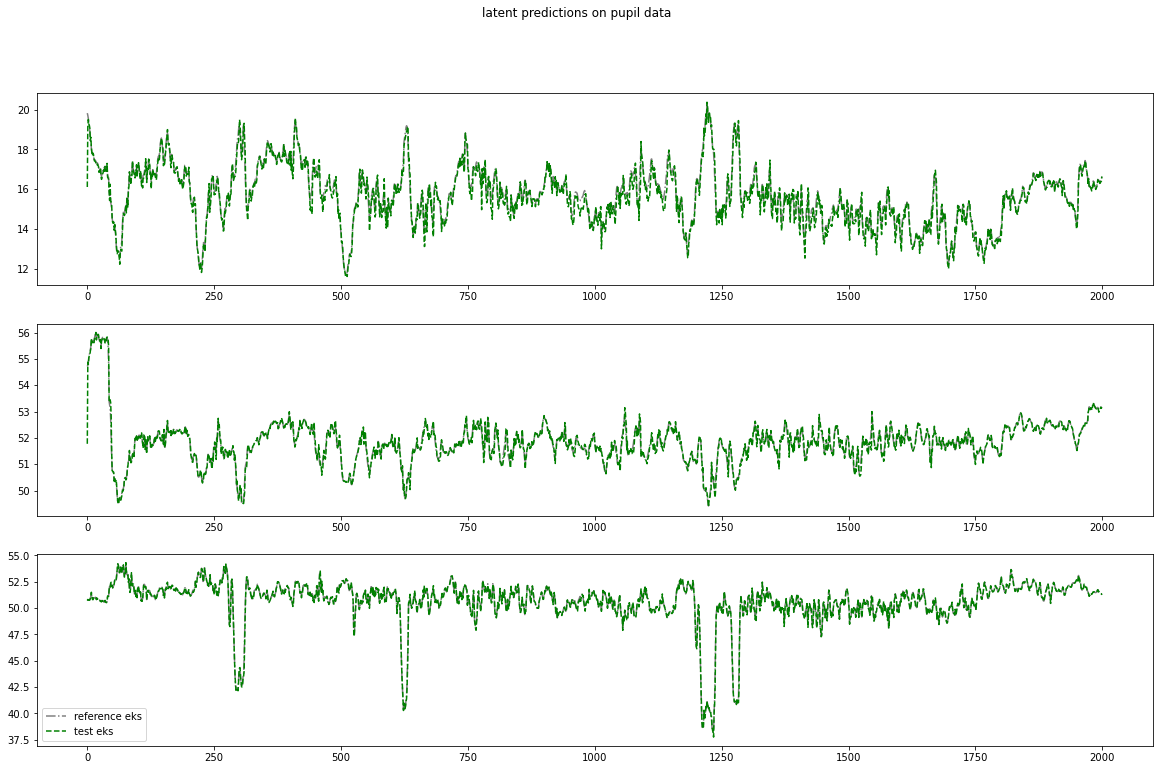

In [41]:
%run -i "scripts/pupil_example.py" --csv-dir 'data/ibl-pupil' --save-dir 'data/misc/pupil-test/' --diameter-s 0.99 --com-s 0.99 --eks_version "opti"

In [42]:
%run -i "scripts/pupil_example.py" --csv-dir 'data/ibl-pupil' --save-dir 'data/misc/pupil-test/' --diameter-s 0.99 --com-s 0.99 --eks_version "standard"

Smoothing matrix: [[0.99 0.   0.  ]
 [0.   0.99 0.  ]
 [0.   0.   0.99]]
filtering...
done filtering
smoothing...
done smoothing
saving smoothed predictions to data/misc/pupil-test/kalman_smoothed_pupil_traces.csv
saving latents to data/misc/pupil-test/kalman_smoothed_latents.csv
see example EKS output at data/misc/pupil-test/example_eks_result.pdf


In [25]:
camera_names = ['main', 'top', 'right']
keypoint_ensemble_list = [
    'head', 'chin_base', 'chin1_4', 'chin_half','chin3_4', 'chin_tip', 'mid', 'fork',
    'stripeA', 'stripeP', 'tail_neck', 'dorsal', 'anal', 'caudal_d', 'caudal_v',
]
tracker_name = 'heatmap_mhcrnn_tracker'
num_cameras = len(camera_names)

# NOTE! replace this path with an absolute path where you want to save EKS outputs
eks_save_dir = 'data/misc/one-video-mirror-fish-predictions/eks_opti'

# path for prediction csvs
file_path = 'data/misc/mirror-fish_ensemble-predictions/network_4/20210204_Quin'
#"/Users/clairehe/Documents/GitHub/eks/data/misc/mirror-fish_ensemble-predictions/network_4/20210204_Quin"

In [43]:
%run -i "scripts/multicam_example.py" --csv-dir "data/mirror-mouse" --bodypart-list ['head', 'chin_base', 'chin1_4', 'chin_half','chin3_4', 'chin_tip', 'mid', 'fork','stripeA', 'stripeP', 'tail_neck', 'dorsal', 'anal', 'caudal_d', 'caudal_v'] --camera-names ['main', 'top', 'right'] --save-dir 'data/misc/one-video-mirror-fish-predictions/eks_opti' --eks_version "opti"

SyntaxError: invalid syntax (multicam_example.py, line 139)

In [33]:
!ls 'data/misc/mirror-fish_ensemble-predictions/network_4/20210204_Quin'

img021615.csv img047982.csv img048906.csv img069800.csv img197707.csv
img025194.csv img048178.csv img049015.csv img184904.csv
img025351.csv img048416.csv img049331.csv img196179.csv


In [35]:
!ls /Users/clairehe/Documents/GitHub/eks/data/mirror-mouse

180607_004.train_frames=75.rng=0.csv 180607_004.train_frames=75.rng=3.csv
180607_004.train_frames=75.rng=1.csv 180607_004.train_frames=75.rng=4.csv
180607_004.train_frames=75.rng=2.csv
